In [1]:
import torch
import geoopt
from geoopt.optim import RiemannianSGD, RiemannianAdam
import matplotlib.pyplot as plt

import numpy as np
from torch.func import grad

import torch
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from torchvision.transforms.functional import rotate
from scipy.linalg import lstsq, null_space

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Get cpu or gpu device for training.
device = "cuda"
print(f"Using {device} device")

Using cuda device


In [3]:
def G(d): # questa è  rot_mat
    mat = np.zeros(d**4).reshape(d**2,d**2)
    for j in range(d):
        for i in range(d):
            k = (i+1)*d-j
            h = i+(j)*d+1

            mat[h-1][k-1] = 1
    return mat

def W(output_dim, d = 4):
    kernel = null_space((np.identity(d*d) -  G(d)).T).T
    W = []
    for j in range(output_dim):
        vec = np.zeros(d**2)
        for k in kernel:
            vec = np.random.random()*k + vec
        W.append(list(vec))
    W = np.array(W)/len(kernel)
    return np.array(W)

In [4]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX = trainX[:10]
trainy = trainy[:10]

trainy = torch.Tensor(trainy).to(device)
trainX = trainX / 256
testX = testX / 256

trainX = torch.Tensor(trainX).to(device)
trainX_90 = rotate(img = trainX, angle = 90)

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=torch.Size([10, 28, 28]), y=torch.Size([10])
Test: X=(10000, 28, 28), y=(10000,)


In [5]:
from torch import nn


class InvariantNN(nn.Module):
    def __init__(self, input_dim, hidden, output):
        super(InvariantNN, self).__init__()
        
#         self.softmax = nn.Softmax()
        
        self.input_dim = input_dim
        self.hidden = hidden
        self.output = output
    
        self.flatten = nn.Flatten(start_dim=1)
        self.l1 = nn.Linear(self.input_dim, self.hidden)
        self.l2 = nn.Linear(self.hidden, self.hidden)
        self.l3 = nn.Linear(self.hidden, self.output)
        
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        
        self.acc_loss = nn.CrossEntropyLoss()
        
    def get_shapes(self):
        shapes = [(self.input_dim, self.hidden), 
                  (self.hidden,1),
                  (self.hidden, self.hidden),
                  (self.hidden,1),
                  (self.hidden, self.output),
                  (self.output,1)
                 ]
        return shapes
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)    
        x = self.tanh(x)
        x = self.l3(x)

        return  x
    
model = InvariantNN(28*28, 64, 10).to(device)

In [6]:
28*28*64 + 64 + 64*64 + 64 * 64*10 + 10

95306

In [7]:
def flatten(weights_list):
    flatten_weights = []
    for weight in weights_list:
        flatten_weights.append(weight.flatten())
        
    return torch.concatenate(flatten_weights)

def deflatten(weights_flat, shapes):
    weigths_list = []
    shape_counter = 0
    for shape in shapes:
        weight = torch.Tensor(weights_flat[shape_counter: shape_counter + np.prod(shape)])
        shape_counter = shape_counter + np.prod(shape)
        
        weigths_list.append(weight.reshape(shape))
            
    return weigths_list

# Funzione che definisce la varietà: sfera unitaria centrata in 0
def g(thetas):
    
    W1, b1, W2, b2, W3, b3 = deflatten(thetas, model.get_shapes())
    model.l1.weight.data = W1.T
    model.l2.weight.data = W2.T
    model.l3.weight.data = W3.T
    model.l1.bias.data = b1.T
    model.l2.bias.data = b2.T
    model.l3.bias.data = b3.T
    
    
    NN1 = model(trainX)
    NN2 = model(trainX_90)
    Delta_NN = NN1 - NN2
    norm = Delta_NN.norm()**2
    
    # Zero grad
    for param in model.parameters():
        param.grad = torch.zeros(param.shape).to(device)
        
    # Compute gradient
    norm.backward()
    
    return norm # sfera unitaria


def dg(thetas):
    _ = g(thetas)
    def_grad = [param.grad for param in model.parameters()]
    
    
    return flatten(def_grad)

# # Gradiente di f
# def dg(thetas):
#     gradient = grad(g)(thetas)
#     return gradient #+ 1e-5*(gradient.norm()==0)


# Classe LevelSetManifold già implementata sopra
class LevelSetManifold(geoopt.manifolds.Manifold):
    
    ndim = 1
    name = "Caste"
    
    def __init__(self, f, df, lr_proj = 1):
        super().__init__()
        self.f = f
        self.df = df
        self.lr_proj = lr_proj

    def _check_point_on_manifold(self, x, atol=1e-7, rtol=1e-7):
        return torch.abs(self.f(x)) < atol

    def _check_vector_on_tangent(self, x, u, atol=1e-7, rtol=1e-7):
        grad_f = self.df(x)
        return torch.abs(u @ grad_f).sum() < atol
    
    def projx(self,x):
        if self._check_point_on_manifold(x):
            return x
        for r in range(100):
            x = self.single_projx(x)
            if r%50==0:
                print("g: ", self.f(x))
                print("dg: ", self.df(x).norm())
            if r == 99:
                print(f"Retraction applied {r + 1} times")
            if self._check_point_on_manifold(x):
                print(f"Retraction applied {r + 1} times")
                break
        return x
    
    def single_projx(self, x):
        """
        Retraction
        """
        grad_f = self.df(x)
        f_val = self.f(x)
        return x - 1*self.lr_proj*(f_val / grad_f.norm()**2 * grad_f)

    def proju(self, x, u):
        """
        Projected gradient
        """
        grad_f = self.df(x)
        return u - 1*(u @ grad_f) / grad_f.norm()**2 * grad_f

    def inner(self, x, u, v=None):
        if v is None:
            v = u
        return (u * v).sum()

    def expmap(self, x, u):
        return self.retr(x, u)

    def egrad2rgrad(self, x, u):
        return self.proju(x, u)

    def retr(self, x, u):
        x_new = x + u
        return self.projx(x_new)

C:\Users\scanu\anaconda3\envs\geo\lib\site-packages\torch\autograd\__init__.py:266: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10, 64], strides() = [64, 1]
param.sizes() = [10, 64], strides() = [1, 10] (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Prima:  g:  0.43777576088905334 dg:  tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')






############ Landing phase #############
g:  tensor(0.4392, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(6.6197, device='cuda:0')
g:  tensor(0.7958, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(9.8786, device='cuda:0')
Retraction applied 100 times
0 g:  2.533600330352783 dg:  tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
g:  tensor(2.5997, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(22.6729, device='cuda:0')
g:  tensor(9.0189, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(68.0983, device='cuda:0')
Retraction applied 100 times
g:  tensor(42.6907, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(245.6805, device='cuda:0')
g:  tensor(76.8506, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(483.3129, device='cuda:0')
Retraction applied 100 times
g:  tensor(163.5717, device='cuda:0', grad_fn=<PowBackward0>)
dg:  tensor(891.2649, device='cuda:0

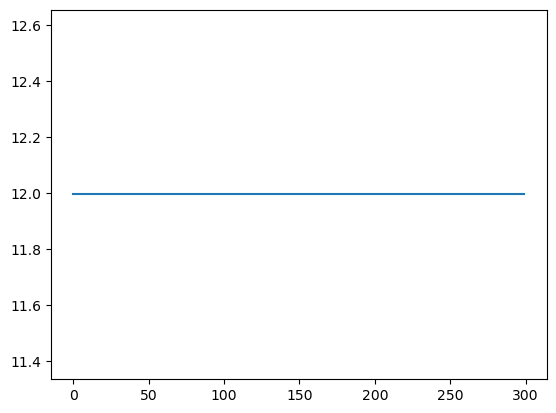

In [8]:
# Creiamo la varietà
manifold = LevelSetManifold(g, dg, 1)
# Test del parametro manifold

theta = flatten(model.parameters()).to(device)
theta = geoopt.ManifoldParameter(theta , manifold=manifold)

print("Prima: ", "g: ", g(theta).item(), "dg: ", dg(theta))

# Proiettiamo il parametro iniziale sulla varietà
print("\n\n\n\n\n")
# print("99", "Primo theta: ",  theta.data)
print("############ Landing phase #############")
for i in range(10):
    
    theta.data = manifold.projx(theta.data)
    if i%20 == 0:
        print(i, "g: ", g(theta).item(), "dg: ", dg(theta))

    if g(theta)< 1e-7:
        print("Landed :)")
        break
        
print("\n\n")


# Verifica che il parametro iniziale appartenga alla varietà
#assert manifold._check_point_on_manifold(theta.data), "Il punto iniziale non è sulla varietà"

# Definiamo una loss function: minimizziamo la norma quadrata
def loss_fn(trainX, theta):
    return torch.nn.CrossEntropyLoss()(model(trainX), trainy.long())  # Ad esempio, massimizzare la componente x[0]

# Ottimizzatore Riemanniano
optimizer = RiemannianSGD([theta], lr=0.01)

# Ciclo di ottimizzazione
g_during_train = []
loss_history = []
print("############## Training phase ################")
for epoch in range(300):
    optimizer.zero_grad()
    loss = loss_fn(trainX, theta)
    loss.backward()
    optimizer.step()
    if epoch%10 == 0:
        print("Epoch",  epoch + 1, 
              "Loss:", loss.item(),
#               "theta:", theta.data[1].item(),
              "g(theta):", round(float(g(theta).data),8))
    loss_history.append(loss.item())
    g_during_train.append(g(theta).data)
# plt.plot(g_during_train)
plt.plot(loss_history)
print("\n\n")

# Risultato finale
print("Punto finale:", theta)
print("Appartiene alla varietà?", manifold._check_point_on_manifold(theta))

In [9]:
model(torch.rand((1,28*28)).to(device))

tensor([[ -4.8218,  -9.2161,  -4.3466,  -5.5885,  -1.9368,   2.8326,   8.4917,
           4.5118,   1.2219, -10.1857]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [10]:
trainX_180 = rotate(img = trainX, angle = 180)
trainX_270 = rotate(img = trainX, angle = 270)

print(model(trainX)[0])
print(model(trainX_90)[0])
print(model(trainX_180)[0])
print(model(trainX_270)[0])

print((model(trainX)[0] - model(trainX_180)[0]).norm()**2)

tensor([-5.5287, -9.4397, -2.2649, -3.4448, -1.1030,  4.9758,  8.5125,  3.5182,
         2.2373, -8.3812], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ -4.2014,  -7.3325,  -4.5015,  -8.1811,   0.2742,   3.0746,  10.7341,
          8.6203,   2.6262, -12.3201], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-4.2178, -8.6134, -1.7216, -3.8780, -2.5200,  4.1737,  8.4461,  2.8710,
         1.6021, -8.8662], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ -4.8070,  -7.2062,  -6.1222,  -6.6201,   2.5847,   6.9334,  12.2857,
          8.2458,   0.1926, -14.0597], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(6.5977, device='cuda:0', grad_fn=<PowBackward0>)


In [11]:
model.parameters() = deflatten(thetas, model.get_shapes())
NN1 = model(trainX)
NN2 = model(trainX_90)
Delta_NN = NN1 - NN2
norm = Delta_NN.norm()**2
print(norm)

SyntaxError: cannot assign to function call (1804443423.py, line 1)

In [ ]:
model.parameters()